In [1]:
from pylab import *
import numpy as np
import matplotlib, pylab
from dcll.npamlib import plotLIF
from dcll.pytorch_libdcll import *
from dcll.load_dvsgestures_sparse import *

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['savefig.dpi']=400.
matplotlib.rcParams['font.size']=14.0
matplotlib.rcParams['figure.figsize']=(5.0,3.5)
matplotlib.rcParams['axes.formatter.limits']=[-10,10]
matplotlib.rcParams['axes.labelsize']= 14.
matplotlib.rcParams['figure.subplot.bottom'] = .2
matplotlib.rcParams['figure.subplot.left'] = .2       

In [17]:
def convergence_multiple(dirs, Nlayers=3):
    res  = np.empty([len(dirs), Nlayers])
    pl = [[] for _ in range(len(dirs))]
    for k, d in enumerate(dirs):
        directory = samples_dir+d
        args = np.load(directory+"args.pkl")
        testepochs = np.arange(0,args.epochs,args.testinterval, dtype='int')
        n_iter_test = 1800
        iter_test = np.arange(1,n_iter_test+20,20)
        Ntests = len(testepochs)
        acc_test = np.load(directory+"acc_test.npy")[:Ntests]

        N = 288

        bs = [args.batchsize for i in range(N//args.batchsize)] 
        if (N%args.batchsize)>0:
            bs.append(N%args.batchsize)

        weights = np.array(bs)/N
        weighted_acc = np.zeros([Ntests,Nlayers],dtype='float')
        for i in range(Nlayers):
            weighted_acc[:,i] = (acc_test[:,:,i]*weights).sum(axis=1)
            
        for l in range(Nlayers):
            x = testepochs*args.batchsize//1000
            y = 1-weighted_acc[:,l]
            xm = x.reshape(-1,5).mean(axis=1)
            ym = y.reshape(-1,5).mean(axis=1)
            res[k,l] = ym[-1]
            pl[k].append(ym)
    return res, np.array(xm), np.array(pl)


In [18]:
samples_dir = '../samples/'
Nlayers = 3
#directory = "Results/105__08-10-2018/"
#directory = "Results/104__04-10-2018/"
#directory = samples_dir+"Results/101__02-10-2018/"
##Best:
#directory = samples_dir+"Results/156__05-11-2018/"
directory = samples_dir+"Results_dvsgestures/023__19-11-2018/"
args = np.load(directory+"args.pkl")
testepochs = np.arange(0,args.epochs,args.testinterval, dtype='int')
n_iter_test = 1800
iter_test = np.arange(1,n_iter_test+20,20)
Ntests = len(testepochs)
acc_test = np.load(directory+"acc_test.npy")[:Ntests]

N = 288

bs = [args.batchsize for i in range(N//args.batchsize)] 
if (N%args.batchsize)>0:
    bs.append(N%args.batchsize)

weights = np.array(bs)/N
weighted_acc = np.zeros([Ntests,Nlayers],dtype='float')
for i in range(Nlayers):
    weighted_acc[:,i] = (acc_test[:,:,i]*weights).sum(axis=1)

In [19]:
res

array([[0.71458333, 0.09916667, 0.05916667],
       [0.73652778, 0.11638889, 0.05819444],
       [0.66625   , 0.11972222, 0.05111111],
       [0.74166667, 0.13375   , 0.05597222],
       [0.75291667, 0.12472222, 0.05888889]])

[0.72180556 0.11902778 0.05819444]
[0.03147787 0.01072776 0.0033564 ]


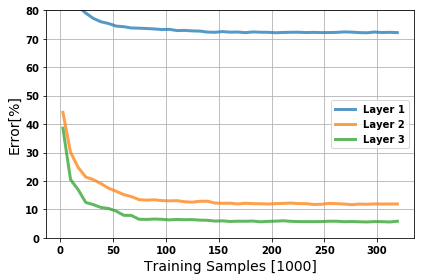

In [20]:
samples_dir = '../samples/'
dirs = [samples_dir+'Results_dvsgestures/020__18-11-2018/',
        samples_dir+'Results_dvsgestures/021__19-11-2018/',
        samples_dir+'Results_dvsgestures/023__19-11-2018/',
        samples_dir+'Results_dvsgestures/024__20-11-2018/',
        samples_dir+'Results_dvsgestures/025__20-11-2018/']
res, xm, ym = convergence_multiple(dirs)
print(res.mean(0))
print(res.std(0))
fig = figure(figsize=(6,4))
ax = subplot(111)      
for l in range(3):
    ax.plot(xm, 100*ym.mean(axis=0)[l,:], linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))

ax.set_yticks(np.arange(0,101,10))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,80])
tight_layout()
savefig(directory+'convergence_dvs_gestures_small.png', dpi=300, frameon=False)

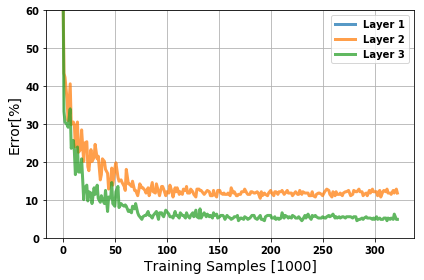

In [8]:
fig = figure()
ax = subplot(111)
for l in range(Nlayers):
    ax.plot(testepochs*args.batchsize//1000, (1-weighted_acc[:,l])*100, linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))
ax.set_yticks(np.arange(0,100*1.1,100*0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,60])
tight_layout()
savefig(directory+'convergence_dvs_gestures.png', dpi=300, frameon=False)


0.663888888888889
0.12083333333333335
0.05208333333333335


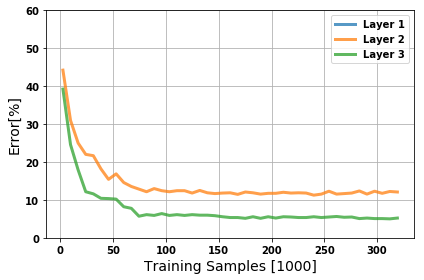

In [9]:
fig = figure(figsize=(6,4))
ax = subplot(111)
for l in range(Nlayers):
    x = testepochs*args.batchsize//1000
    y = 1-weighted_acc[:,l]
    xm = x.reshape(-1,5).mean(axis=1)
    ym = y.reshape(-1,5).mean(axis=1)
    ax.plot(xm, 100*ym, linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))
    print(ym[-1])
ax.set_yticks(np.arange(0,100*1.1,100*0.1))
ax.grid()
legend()
ax.set_ylabel('Error[%]')
ax.set_xlabel('Training Samples [1000]')
ax.set_ylim([0,60])
tight_layout()
savefig(directory+'convergence_dvs_gestures_small.png', dpi=300, frameon=False)


0.663888888888889
0.12083333333333335
0.05208333333333335
../samples/Results_dvsgestures/023__19-11-2018/convergence_dvs_gestures_small_largefonts.png


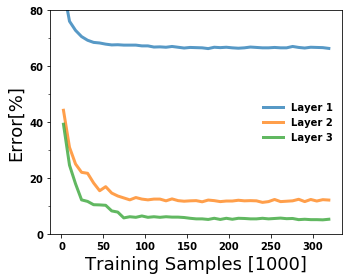

In [10]:
fig = figure(figsize=(5,4))
ax = subplot(111)
for l in range(Nlayers):
    x = testepochs*args.batchsize//1000
    y = 1-weighted_acc[:,l]
    xm = x.reshape(-1,5).mean(axis=1)
    ym = y.reshape(-1,5).mean(axis=1)
    ax.plot(xm, 100*ym, linewidth=3, alpha=.75, label = 'Layer {}'.format(l+1))
    print(ym[-1])
ax.set_yticks(np.arange(0,1.1*100,0.1*100))
ax.grid()
legend(frameon=False)
ax.set_ylabel('Error[%]', fontsize=18)
ax.set_xlabel('Training Samples [1000]', fontsize=18)
ax.set_ylim([0,80])
ax.set_yticks([0,20,40,60,80], minor=False)
ax.set_yticks([10,30,50,70], minor=True)
ax.xaxis.grid(False, which='major')
ax.yaxis.grid(False, which='major')
ax.yaxis.grid(False, which='minor')
tight_layout()

savefig(directory+'convergence_dvs_gestures_small_largefonts.png', dpi=500, frameon=False)
print(directory+'convergence_dvs_gestures_small_largefonts.png')


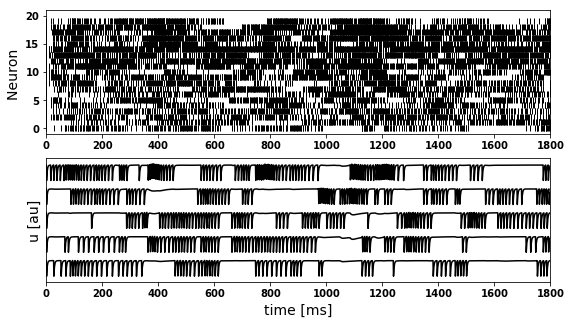

<Figure size 432x288 with 0 Axes>

In [8]:
voutput = np.load(directory+"doutput4.npy")
soutput = np.load(directory+"doutput1.npy")
soutput = soutput.reshape(soutput.shape[0],  -1)
voutput = voutput.reshape(voutput.shape[0],  -1)
fig = figure(figsize=[10,5])
ax1, ax2 = plotLIF(voutput[:,0:5],soutput[:,0:20],  staggering=1, color='k')
ax2.set_ylabel('Neuron')
ax2.set_xlabel('Time [ms]')

tight_layout()
fig.savefig(directory+'convergence_dvs_gestures_raster.png',dpi = 300)

In [12]:
from tqdm import tqdm
def accuracy_by_vote(pvoutput, labels):
    from collections import Counter
    pvoutput_ = np.array(pvoutput).T
    n = len(pvoutput_)
    arr = np.empty(n)
    arrl = np.empty(n)
    labels_ = labels.argmax(axis=2).T
    for i in range(n):
        arr[i] = Counter(pvoutput_[i]).most_common(1)[0][0]
        arrl[i] = Counter(labels_[i]).most_common(1)[0][0]
    return float(np.mean((arr == arrl)))

labels = np.load(directory + "testlabels.npy")
inputrate = np.load(directory + "testinputrate.npy")
accs = [[] for i in range(Nlayers)]
for l in range(Nlayers):    
    clout = np.load(directory + "clout{}.npy".format(l+1))
    for i in tqdm(iter_test):
        accs[l].append(accuracy_by_vote(clout[0:i],labels))
        

100%|██████████| 91/91 [00:08<00:00,  7.89it/s]


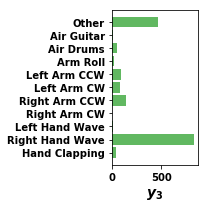

In [41]:
from collections import Counter
ct = Counter(clout[:,1])
act = np.zeros(11)
gests = []
for i in range(11):
    if i in ct.keys(): act[i] = ct[i]
    gests.append(mapping[i])
figure(figsize=(3,3))
barh(range(11), act, align='center', color="#61b861", ecolor='black') 
yticks(range(11),gests)
xlabel('$y_3$')
tight_layout()
savefig(directory+'y3_count')

In [18]:
ct

Counter({4: 146,
         8: 53,
         10: 463,
         6: 90,
         3: 5,
         1: 831,
         2: 8,
         7: 23,
         5: 83,
         0: 40,
         9: 9})

0.6701388888888888
0.11805555555555558
0.05902777777777779


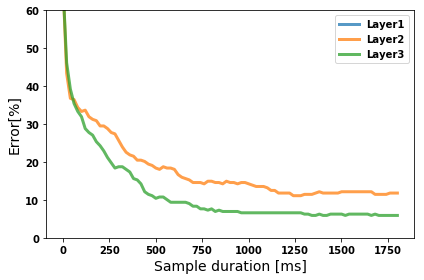

In [13]:
fig = figure()
#ax0 = subplot(211)
ax1 = subplot(111)
#ax0.plot(inputrate[1:], color='k', linewidth=3, alpha=.75)
for l in range(Nlayers):
    ax1.plot(iter_test,100*(1-np.array(accs[l])), linewidth=3, alpha=.75, label = "Layer{}".format(l+1))
    print(1-accs[l][-1])
ax1.set_ylabel('Error[%]')
ax1.set_xlabel('Sample duration [ms]')
ax1.set_ylim([0,60])
legend()
tight_layout()
savefig(directory+'convergence_dvs_gestures_sampleduration.png')

In [29]:
input_test = np.load(directory + "testinput.npy")

In [30]:
def plot_gestures_imshow(images, labels, nim=11, avg=50, do1h = True, transpose=False):
    from matplotlib import colors
    import numpy as np

    np.random.seed(101)
    zvals = np.random.rand(100, 100) * 10

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['red','black', 'black','green'])
    bounds=[-1,-0.1,.1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    import pylab as plt
    plt.figure(figsize = [20,16])
    import matplotlib.gridspec as gridspec
    if not transpose:
        gs = gridspec.GridSpec(images.shape[1]//avg, nim)
    else:
        gs = gridspec.GridSpec(nim, images.shape[1]//avg)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=.0, hspace=.04)
    if do1h:
        categories = labels.argmax(axis=1)
    else:
        categories = labels
    s=[]
    for j in range(nim):
         for i in range(images.shape[1]//avg):
             if not transpose:
                 ax = plt.subplot(gs[i, j])
             else:
                 ax = plt.subplot(gs[j, i])
             on_event = images[j,i*avg:(i*avg+avg),0,:,:].sum(axis=0).T
             off_event = -images[j,i*avg:(i*avg+avg),1,:,:].sum(axis=0).T
             plt.imshow(on_event+off_event, cmap=cmap, norm=norm, interpolation='nearest')
             plt.xticks([])
             if i==0: 
                plt.title(mapping[labels[0,j].argmax()], fontsize=20)
             plt.text(3,5,'t={}ms'.format(i*avg),color='white')
             plt.yticks([])
         s.append(images[j].sum())
    print(s)

[1813.0, 3574.0, 2690.0, 7347.0, 8620.0]


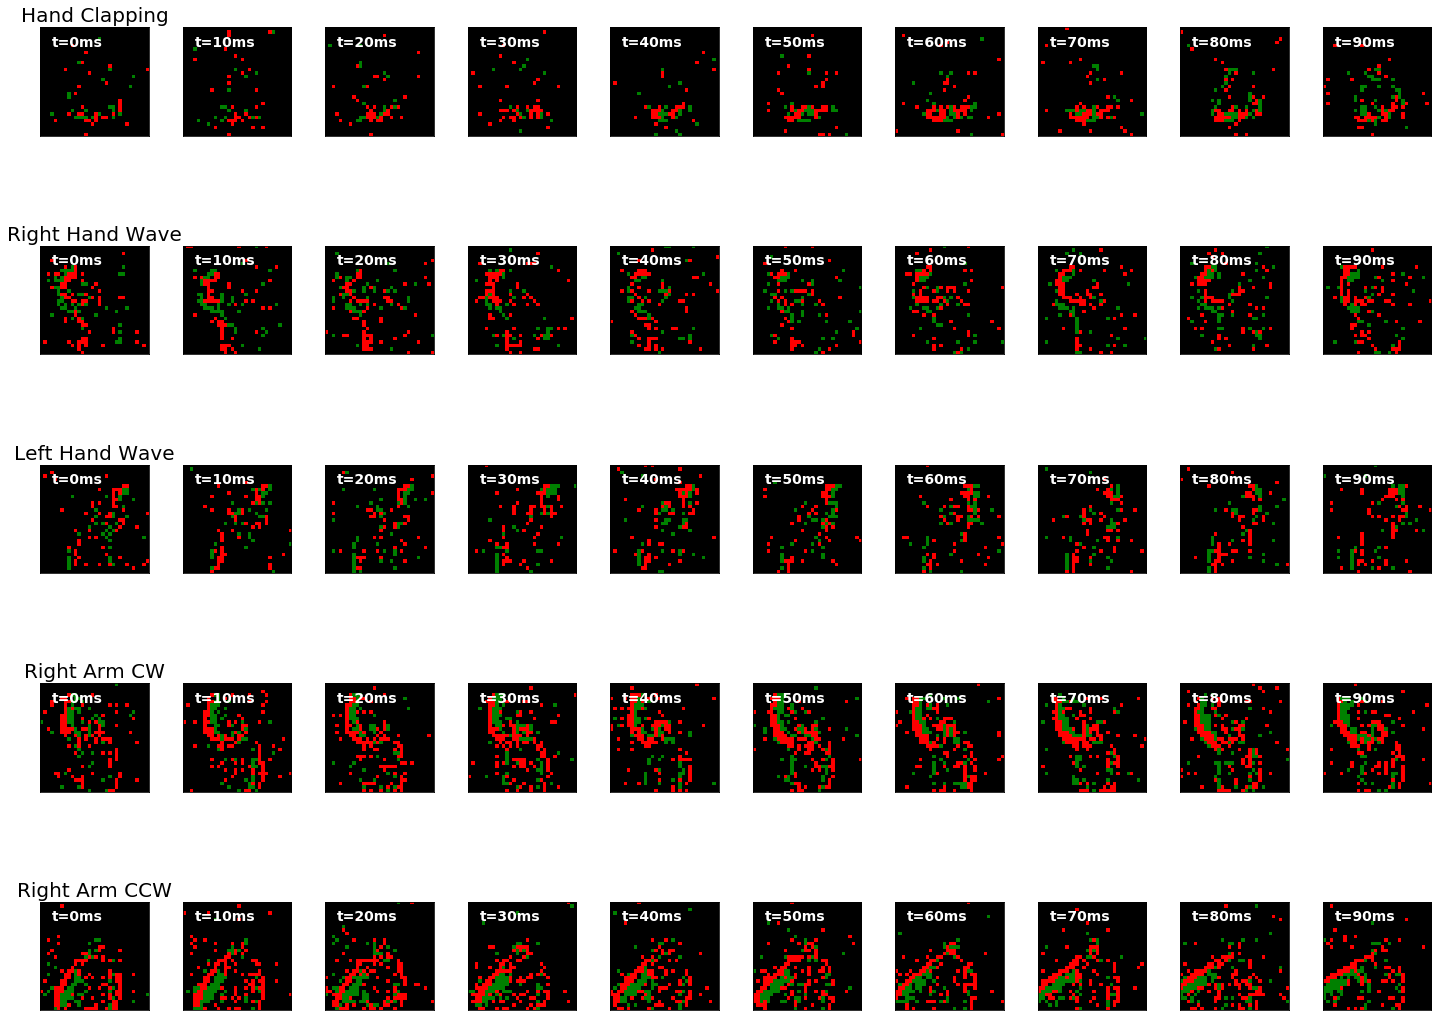

In [31]:
plot_gestures_imshow(input_test[:100].swapaxes(0,1),labels[:5],nim=5, transpose=True, avg=10)
tight_layout()
savefig(directory+'convergence_dvs_gestures_sample.png')

In [98]:
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [140]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 
inn = np.load(directory+'testinput.npy')
inn0 = inn[:,1,1,:].squeeze()
fig = plt.figure()
ax = plt.axes(projection='3d')
t,x,y = np.where(inn0==1)
col = np.arange(len(t))
jet()
ts = 190
idx = np.where(t==ts)[0]
print(len(idx))
ax.plot_surface(X,np.ones_like(Y)*(ts),Y, alpha=.3)
ax.scatter3D(x[idx], t[idx], y[idx], 'filled', color='black', marker='o', alpha=1.0)
ax.scatter3D(x[:idx[0]:1], t[:idx[0]:1], y[:idx[0]:1], 'filled', color='gray', marker='o', alpha=.05)
ax.scatter3D(x[idx[0]:10000:1], t[idx[0]:10000:1], y[idx[0]:10000:1], 'filled', c=col[idx[0]:10000:1], marker='o', alpha=.05)
a = Arrow3D([0, 0], [0, 500], 
                [33, 33], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="k")
X = np.array([0,32,0,32])
Y = np.array([0,0,32,32])
X, Y = np.meshgrid(X, Y)
ax.view_init(elev=-157, azim=-44) 
ax.grid(False)
ax.xaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_visible(False)
ax.set_axis_off()
ax.yaxis.set_visible(True)
ax.add_artist(a)
#?ax.text(-15, ts+20, 35, 'Time[ms]')
tight_layout()
savefig(directory+'dvs_3d_plot.png', format='png')

FigureCanvasNbAgg()

19


In [41]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x7fad04baec88>),
             ('right', <matplotlib.spines.Spine at 0x7fad04bae518>),
             ('bottom', <matplotlib.spines.Spine at 0x7fad04bae208>),
             ('top', <matplotlib.spines.Spine at 0x7fad04baea90>)])

In [113]:
ax.elev

-157.1760797342189

In [114]:
ax.azim

-44.83370288248534

In [143]:
t[10000]

496